In [4]:
import glob
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
def comment_motion_detector(comment: str):
    keywords = ["motion", "moion", "motio", "ringing", "rinin", "ringin"]
    tocmp = comment.lower()
    return any(map(lambda x: x in tocmp, keywords))


def train_val_test(data, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    x_train, x_test = train_test_split(data, test_size=1 - train_prop)
    x_val, x_test = train_test_split(
        x_test, test_size=test_prop / (test_prop + val_prop)
    )
    return x_train, x_val, x_test

## AMPSCZ

In [31]:
ampscz_scores = pd.read_csv("AMPSCZ_scores.csv")
ampscz_scores["sub-ses"] = (
    ampscz_scores["sub_id_gs"].astype(str)
    + "-"
    + ampscz_scores["ses_id_gs"].astype(str)
)
ampscz_scores["score"] = (
    ampscz_scores["score"].replace("-", "-1").fillna("-1").astype(int)
)
ampscz_scores["comment"] = ampscz_scores["comment"].fillna("")
ampscz_scores["site"] = ampscz_scores["sub_id_gs"].str[0:2]
ampscz_scores

,sub_id_gs,ses_id_gs,timepoint_gs,score,comment,sub-ses,site
0,BI02450,202306231,month_2_arm_1,2,"severe ringing, ghosting at eyes, motion",BI02450-202306231,BI
1,BI02450,202304111,baseline_arm_1,3,ringing throughout,BI02450-202304111,BI
2,BI04369,202312081,NaN,-1,,BI04369-202312081,BI
3,BI05529,202306051,baseline_arm_2,4,no notable issues,BI05529-202306051,BI
4,BI05529,202312011,NaN,-1,,BI05529-202312011,BI
...,...,...,...,...,...,...,...
1124,YA29906,202310251,baseline_arm_1,-1,,YA29906-202310251,YA
1125,YA32806,202310201,baseline_arm_1,-1,,YA32806-202310201,YA
1126,YA33149,202311221,baseline_arm_1,-1,,YA33149-202311221,YA
1127,YA33555,202311011,baseline_arm_1,-1,,YA33555-202311011,YA


In [5]:
ampscz_preproc = glob.glob(
    "/home/at70870/narval/scratch/AMPSCZ-Preproc/subjects/sub-*/ses-*/t1_linear/*_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz"
)
len(ampscz_preproc)

1119

In [19]:
sub = list(map(lambda x: x.split(r"/")[7:9], ampscz_preproc))
sub = list(map(lambda x: x[0].strip("sub-") + "-" + x[1].strip("ses-"), sub))
sub

['ME54339-202311161',
 'MT07364-202303271',
 'MT07364-202212211',
 'MT08124-202304131',
 'MT08124-202301201',
 'BM10164-202310131',
 'SD05710-202305181',
 'SD05710-202303161',
 'NC13774-202302271',
 'NC13774-202307101',
 'KC26265-202311171',
 'YA18404-202308241',
 'ME83439-202309081',
 'ME83439-202306301',
 'ME67984-202309151',
 'ME03013-202211251',
 'ME03013-202302101',
 'OR03988-202303301',
 'OR03988-202301271',
 'YA08362-202210131',
 'CP04453-202310051',
 'OR19379-202311221',
 'MU07138-202309111',
 'MT18272-202309051',
 'MT18272-202307021',
 'BM99192-202301311',
 'BM99192-202304191',
 'WU11737-202306291',
 'WU11737-202310171',
 'HK41458-202312011',
 'ME61146-202311231',
 'ME61146-202305121',
 'PI10215-202303161',
 'PI10215-202304101',
 'PI10215-202305191',
 'HK89674-202311291',
 'HK89674-202309131',
 'TE07527-202306071',
 'TE07527-202303171',
 'PA15669-202306141',
 'GA13567-202306061',
 'BI11459-202307271',
 'YA23168-202310261',
 'YA23168-202308211',
 'NN01442-202211281',
 'NN01442-

<Axes: xlabel='Count', ylabel='site'>

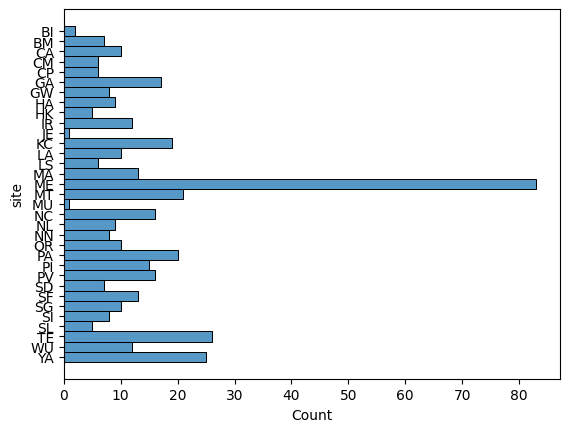

In [231]:
preproc_mask = ampscz_scores["sub-ses"].isin(sub)
ampscz_existing = ampscz_scores[preproc_mask]
ampscz_existing = ampscz_existing[ampscz_existing["score"] > -1]
ampscz_existing["motion"] = ampscz_existing["comment"].apply(
    comment_motion_detector
) | (ampscz_existing["score"] < 3)
motion_free_ampscz = ampscz_existing[ampscz_existing["motion"] == False]
sb.histplot(motion_free_ampscz, y="site")

In [242]:
site_pretrain, site_finetune = train_test_split(
    ampscz_existing["site"].unique(), test_size=0.2
)
len(site_pretrain), len(site_finetune)

(26, 7)

/tmp/ipykernel_45162/908408185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrain_val["group"]="val"
/tmp/ipykernel_45162/908408185.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrain_test["group"]="test"
/tmp/ipykernel_45162/908408185.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

(254, 33, 32)

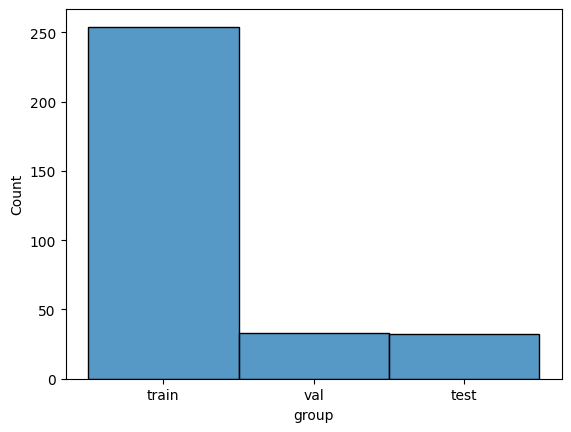

In [379]:
data_samples = motion_free_ampscz[motion_free_ampscz["site"].isin(site_pretrain)]

pretrain_sub_train, pretrain_sub_val, pretrain_sub_test = train_val_test(
    data_samples["sub_id_gs"].unique(), 0.8, 0.1, 0.1
)
pretrain_train = data_samples[data_samples["sub_id_gs"].isin(pretrain_sub_train)]
pretrain_val = data_samples[data_samples["sub_id_gs"].isin(pretrain_sub_val)]
pretrain_test = data_samples[data_samples["sub_id_gs"].isin(pretrain_sub_test)]

pretrain_val["group"] = "val"
pretrain_test["group"] = "test"
pretrain_train["group"] = "train"
pretrain_df = pd.concat([pretrain_train, pretrain_val, pretrain_test])
sb.histplot(pretrain_df, x="group", multiple="dodge")
len(pretrain_train), len(pretrain_val), len(pretrain_test)

/tmp/ipykernel_45162/934929293.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetune_val["group"]="val"
/tmp/ipykernel_45162/934929293.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetune_test["group"]="test"
/tmp/ipykernel_45162/934929293.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

(116, 39, 42)

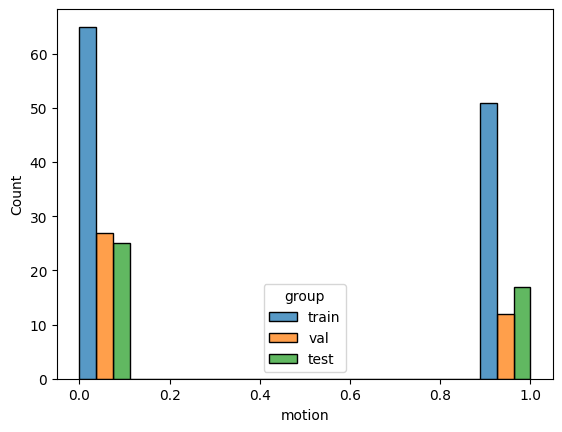

In [320]:
data_samples = ampscz_existing[ampscz_existing["site"].isin(site_finetune)]
finetune_sub_train, finetune_sub_val, finetune_sub_test = train_val_test(
    data_samples["sub_id_gs"].unique(), 0.6, 0.2, 0.2
)
finetune_train = data_samples[data_samples["sub_id_gs"].isin(finetune_sub_train)]
finetune_val = data_samples[data_samples["sub_id_gs"].isin(finetune_sub_val)]
finetune_test = data_samples[data_samples["sub_id_gs"].isin(finetune_sub_test)]

finetune_val["group"] = "val"
finetune_test["group"] = "test"
finetune_train["group"] = "train"
finetune_df = pd.concat([finetune_train, finetune_val, finetune_test])
sb.histplot(finetune_df, x="motion", hue="group", multiple="dodge")

len(finetune_train), len(finetune_val), len(finetune_test)

In [364]:
def find_corresponding_data_ampscz(x, data):
    sub_filtered = list(filter(lambda path: "sub-" + x[0] in path, data))
    ses_filtered = list(filter(lambda path: "ses-" + str(x[1]) in path, sub_filtered))
    if len(ses_filtered) == 1:
        return ses_filtered[0]
    print(
        f"problem with pair:{x}, find matching files ({len(ses_filtered)}) : {ses_filtered}"
    )
    return "None"

In [380]:
data = list(
    map(lambda x: x.removeprefix("/home/at70870/narval/scratch/"), ampscz_preproc)
)
finetune_df["data"] = finetune_df[["sub_id_gs", "ses_id_gs"]].apply(
    lambda x: find_corresponding_data_ampscz(x, data), axis=1, raw=True
)
filt_finetune_df = finetune_df[finetune_df["data"] != "None"]

pretrain_df["data"] = pretrain_df[["sub_id_gs", "ses_id_gs"]].apply(
    lambda x: find_corresponding_data_ampscz(x, data), axis=1, raw=True
)
filt_pretrain_df = pretrain_df[pretrain_df["data"] != "None"]

problem with pair:['SF14052' 202304101], find matching files (2) : ['AMPSCZ-Preproc/subjects/sub-SF14052/ses-202304102/t1_linear/sub-SF14052_ses-202304101_rec-norm_run-1_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz', 'AMPSCZ-Preproc/subjects/sub-SF14052/ses-202304101/t1_linear/sub-SF14052_ses-202304101_rec-norm_run-1_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz']


In [381]:
filt_pretrain_df.to_csv("../src/dataset/ampscz/pretrain.csv")
filt_finetune_df.to_csv("../src/dataset/ampscz/finetune.csv")
sites = pd.DataFrame(
    np.array(
        [
            np.hstack([site_pretrain, site_finetune]),
            ["pretrain"] * len(site_pretrain) + ["finetune"] * len(site_finetune),
        ]
    ).T,
    columns=["site", "group"],
)
sites.to_csv("../src/dataset/ampscz/sites.csv")

## HCPEP

In [1]:
hcpep_preproc = glob.glob(
    "/home/at70870/narval/scratch/HCPEP-Preproc/subjects/sub-*/ses-*/t1_linear/*_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz"
)
len(hcpep_preproc)

NameError: name 'glob' is not defined

In [7]:
hcpep_scores = pd.read_csv("notebooks/hcpep_scores.csv")
hcpep_scores["T1w"] = (
    hcpep_scores["T1w"]
    .fillna("-1")
    .replace("2?", "-1")
    .replace("3/4", "3.5")
    .replace("3 / 4", "3.5")
    .replace("2/3", "2.5")
    .replace("3/2", "2.5")
    .replace("4/3", "3.5")
    .replace("2/ 3", "3.5")
    .astype(float)
)
hcpep_scores["T1w comment"] = hcpep_scores["T1w comment"].fillna("")
hcpep_scores["motion_free"] = ~(
    hcpep_scores["T1w comment"].apply(comment_motion_detector)
    | (hcpep_scores["T1w"] <= 2)
)
hcpep_scores["sub_id"] = hcpep_scores["Subject ID"].str[:4]
hcpep_scores["ses_id"] = hcpep_scores["Subject ID"].str[-1]

hcpep_scores

,Date,Subject ID,T1w,T1w comment,T2w,T2w comment,Center,motion_free,sub_id,ses_id
0,14/8/2018,2031_MR1,-1.0,moving from BWH,NaN,NaN,McLean,False,2031,1
1,14/11/2019,4002_MR2,4.0,,3,noise,McLean,True,4002,2
2,18/12/2019,4012_MR1,3.5,couldnt tell if the motion was a computer arti...,3,faint ringing,McLean,False,4012,1
3,25/7/2018,4015_MR1,3.5,mild ringing,3/4,mild ringing,McLean,False,4015,1
4,19/11/2018,4017_MR1,4.0,,2/3,ringing motion,McLean,True,4017,1
...,...,...,...,...,...,...,...,...,...,...
397,8/8/2022,2065_MR1,3.0,Minor ghosting of eyeballs,3,Slight ringing especially in skull,BWH,True,2065,1
398,1/9/2022,6001_MR1,3.5,"slight ringing, ghosting in eyes",4,NaN,BWH,False,6001,1
399,9/9/2022,2010_MR1,4.0,very faint ringing in a few frames,4,NaN,BWH,False,2010,1
400,25/8/2023,2023_MR2,4.0,no notable issues,4,no notable issues,BWH,True,2023,2


In [21]:
hcpep_scored = hcpep_scores[hcpep_scores["T1w"] >= 1]
hcpep_scored["T1w"].round().value_counts(), hcpep_scored["T1w"].value_counts()
hcpep_scored["T1w"].round().value_counts().div(len(hcpep_scored)).mul(100)

T1w
4.0    60.659898
3.0    29.695431
2.0     8.629442
1.0     1.015228
Name: count, dtype: float64

In [8]:
sub = list(map(lambda x: x.split(r"/")[7:9], hcpep_preproc))
sub = list(map(lambda x: x[0].strip("sub-") + "_MR" + x[1].strip("ses-"), sub))
existing_hcpep = hcpep_scores[hcpep_scores["Subject ID"].isin(sub)]
len(existing_hcpep)

NameError: name 'hcpep_preproc' is not defined

In [371]:
motion_free_hcpep = existing_hcpep[hcpep_scores["motion_free"]]
len(motion_free_hcpep)

/tmp/ipykernel_45162/2690599099.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  motion_free_hcpep = existing_hcpep[hcpep_scores['motion_free']]


143

/tmp/ipykernel_45162/2793301638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrain_val["group"]="val"
/tmp/ipykernel_45162/2793301638.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrain_test["group"]="test"
/tmp/ipykernel_45162/2793301638.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

(115, 14, 14)

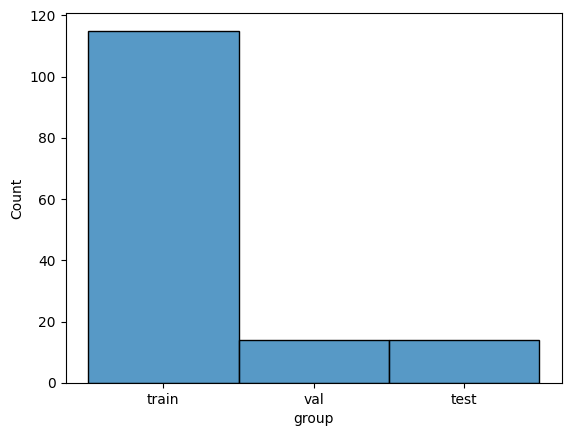

In [372]:
data_samples = motion_free_hcpep

pretrain_sub_train, pretrain_sub_val, pretrain_sub_test = train_val_test(
    data_samples["sub_id"].unique(), 0.8, 0.1, 0.1
)
pretrain_train = data_samples[data_samples["sub_id"].isin(pretrain_sub_train)]
pretrain_val = data_samples[data_samples["sub_id"].isin(pretrain_sub_val)]
pretrain_test = data_samples[data_samples["sub_id"].isin(pretrain_sub_test)]

pretrain_val["group"] = "val"
pretrain_test["group"] = "test"
pretrain_train["group"] = "train"
pretrain_df = pd.concat([pretrain_train, pretrain_val, pretrain_test])
sb.histplot(pretrain_df, x="group", multiple="dodge")
len(pretrain_train), len(pretrain_val), len(pretrain_test)

In [375]:
data = list(
    map(lambda x: x.removeprefix("/home/at70870/narval/scratch/"), hcpep_preproc)
)
pretrain_df["data"] = pretrain_df[["sub_id", "ses_id"]].apply(
    lambda x: find_corresponding_data_ampscz(x, data), axis=1, raw=True
)
filt_pretrain_df = pretrain_df[pretrain_df["data"] != "None"]

In [376]:
filt_pretrain_df.to_csv("../src/dataset/hcpep/pretrain.csv")